In [3]:
import numpy as numpy
from pylab import *

import skimage
from skimage import util
import scipy
from scipy import ndimage
from skimage import restoration
import matplotlib.pyplot as plt


# 1. Zadatak
1) Napisati funkciju coin_mask koja za ulaznu sliku (img_in) kreira binarnu masku takvu da vrednost 1 imaju pikseli koji pripadaju novčićima, dok vrednost 0 ima ostatak slike. Potrebno je da segmentacija bude što preciznija i da novčići nemaju rupice. Segmentacija se vrši na osnovu karakteristika novčića ili pozadine, geomertije, i uz pomoć morfoloških operacija.

Binarizovanje slike je odrađeno pomoću lab kolor sistema. A komponenta predstavlja razliku crvene i zelene boje i zbog zelene pozadine, lako je odvojiti šta je pozadina a šta objekti na slici. Filtriranjem medijan filtrom se uklanjaju eventualni usamljeni pikseli ili manje grupacije piksela i ostaje broj objekata kolliko ima novčića, koji se pomoću otsu praga izdvajaju iz pozadine.

In [4]:
img = imread('coins/coins9.jpg');
img1 = imread('coins/coins5.jpg');


In [5]:
def coin_mask(img_in):
    # Opis funkcije
    # 
    # img_in ulazna slika koju treba binarizovati

    img_lab = skimage.color.rgb2lab(img_in); # prelazak iz rgb u lab sistem

    im = img_lab[:,:,1] # Uzimanje a komponente slike

    im = im+abs(min(im.flatten())) # Vraćanje na opseg 0-255

    im = scipy.ndimage.median_filter(im, size=(13,13), mode='reflect') # Filtriranje medijan filtrom

  
    thresh_otsu = skimage.filters.threshold_otsu(im.flatten()) # određivanje otsu praga

    im_bin = copy(im)
    im_bin[im>thresh_otsu] = 255 # novčići
    im_bin[im<=thresh_otsu] = 0 # pozadina
    
    return im_bin
        

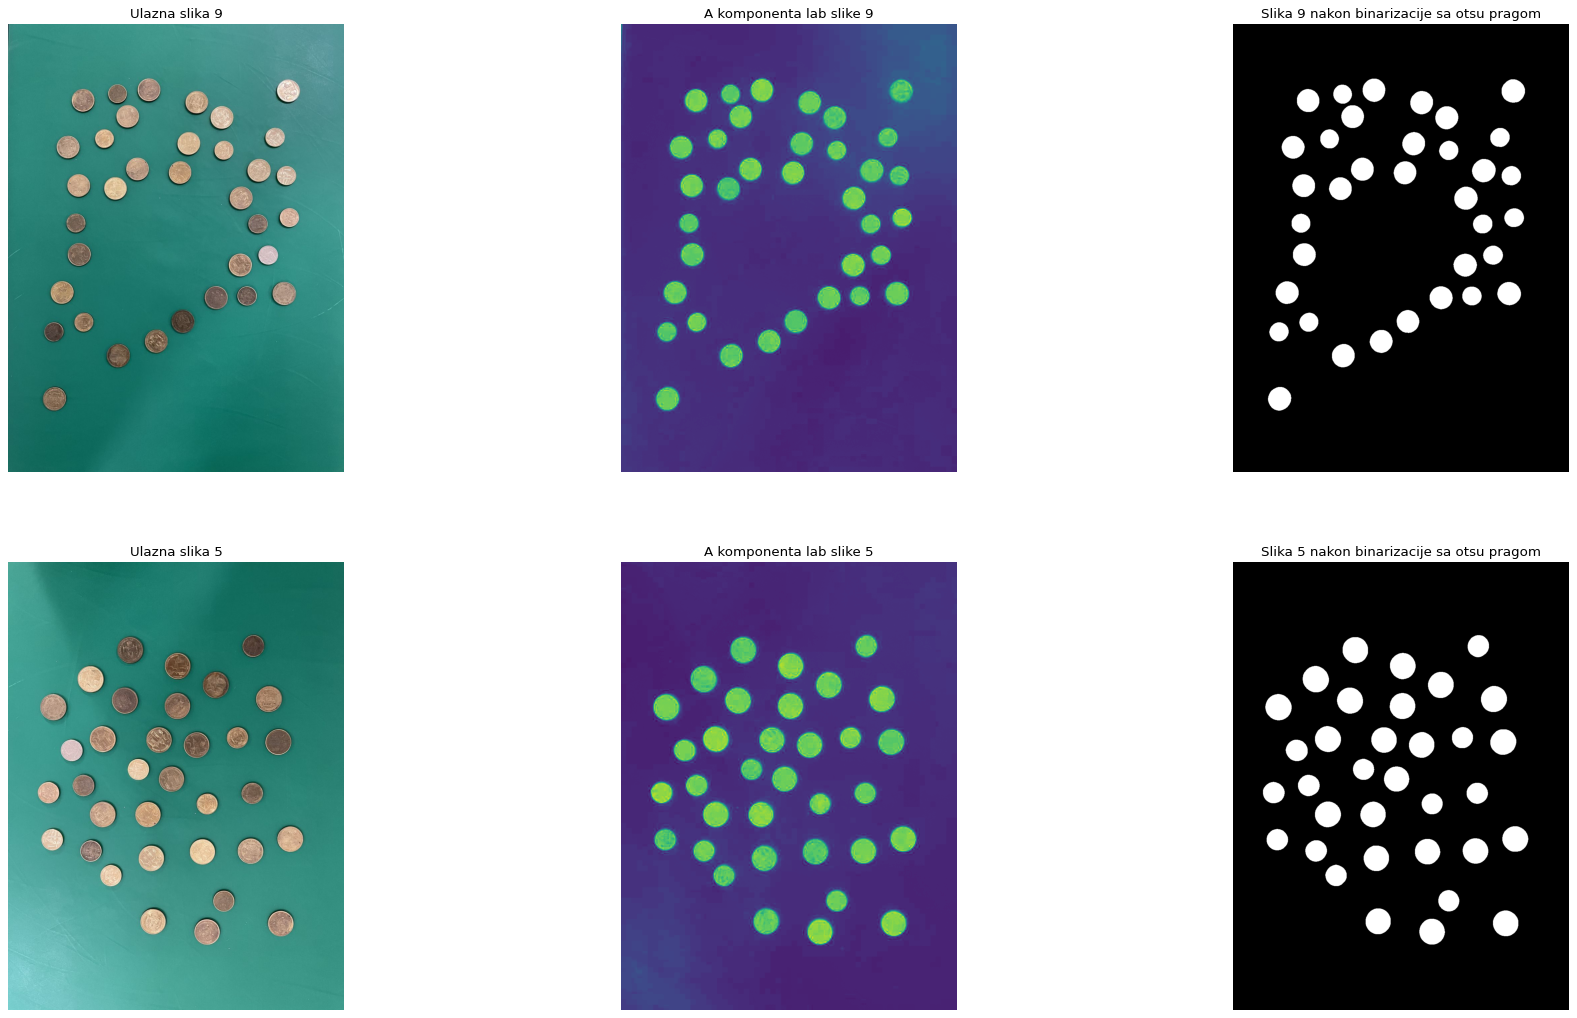

In [6]:
img_bin = coin_mask(img)
img_bin1 = coin_mask(img1)
img_a = skimage.color.rgb2lab(img)[:,:,1]
img_a1 = skimage.color.rgb2lab(img1)[:,:,1]

fig,axes = plt.subplots(nrows=2,ncols=3,figsize=(28,16), dpi=80)
ax = axes.ravel()

ax[0].imshow(img); ax[0].axis('off'); ax[0].set_title('Ulazna slika 9');
ax[1].imshow(img_a), ax[1].axis('off'), ax[1].set_title('A komponenta lab slike 9');
ax[2].imshow(img_bin,cmap='gray');  ax[2].set_title('Slika 9 nakon binarizacije sa otsu pragom'); ax[2].axis('off')


ax[3].imshow(img1); ax[3].axis('off'); ax[3].set_title('Ulazna slika 5');
ax[4].imshow(img_a1); ax[4].axis('off'), ax[4].set_title('A komponenta lab slike 5');
ax[5].imshow(img_bin1,cmap='gray');  ax[5].set_title('Slika 5 nakon binarizacije sa otsu pragom'); ax[5].axis('off');



2) Napisati funkciju bw_label koja na osnovu binarne slike izdvojenih regiona od interesa pravi listu povezanih regiona i dodeljuje im labelu. Pod povezanim regionom se smatra površina sa pikselima vrednosti 1 (iz binarne slike) koji su međusobno povezani1. Algoritam za određivanje povezanih regiona obrađen je na predavanjima. Dva piksela su povezana ako se jedan nalazi u okolini 8 drugog, to jest ako se dodiruju stranicama ili temenima (dijagonalni piskeli).

In [7]:
def bw_label(img_bin):
    # Opis funkcije
    #
    # img_bin - Binarizovana slika
    #
    # Funkcija je realizovana tako da se prolazi kroz svaki piksel. Kada se nađe piksel sa vrednosću 255 (beo piksel) gleda se da
    # li ima levog suseda koji je beo i da li je neki od tri piksela iznad njega beo. Ukoliko su svi ti pikseli crni, trenutni piksel dobija 
    # novu vrednost labele, ukoliko postoji samo levi beli sused, ili samo beli piksel iznad, trenutni piksel dobija tu vrednost labele.
    # Ako postoje i levi i sused odozgo, piksel uzima vrednost levog, ali se uparuje i sa gornjim pikselom i taj par se smešta u listu parova
    # koje su zapravo iste labele. Nakon prolaska kroz sve piksele, svi parovi koji su iste labele dobijaju iste vrednosti i na izlazu se dobija
    # slika koja ima onoliko različitih vrednosti koliko i labela, a pikseli imaju vrednost jednaku broju labele.
    # 
    lista = []
    img_pad = np.pad(img_bin,(1,1),'constant') # Pedovanje slike da bi se izbegla provera graničnih uslova pri iteraciji kroz sliku
    label=20
    for i in range(1,shape(img_bin)[0]):
        for j in range(1,shape(img_bin)[1]):
            if(img_pad[i,j]==255):  # Provera da li je trenutni piksel beo
                 if(img_pad[i,j-1] !=0 ): # Provera da li je levi piksel beo
                    img_pad[i,j]=img_pad[i,j-1] # Preuzimanje labele od levog piksela
                    if(img_pad[i-1,j-1] !=0 or img_pad[i-1,j]!=0 or img_pad[i-1,j+1]!=0):
                        if(img_pad[i-1,j-1] !=0): 
                            if(img_pad[i-1,j-1] !=img_pad[i,j]):
                                par = []
                                par.append(img_pad[i-1,j-1])
                                par.append(img_pad[i,j])
                                if par not in lista:
                                    lista.append(par) # Uparivanje sa istom labelom i dodavanje u listu istih labela
                        elif(img_pad[i-1,j] !=0): 
                            if(img_pad[i-1,j] !=img_pad[i,j]):
                                par = []
                                par.append(img_pad[i-1,j])
                                par.append(img_pad[i,j])
                                if par not in lista:
                                    lista.append(par)
                        elif(img_pad[i-1,j+1] !=0): 
                            if(img_pad[i-1,j+1] !=img_pad[i,j]):
                                par = []
                                par.append(img_pad[i-1,j+1])
                                par.append(img_pad[i,j])
                                if par not in lista:
                                    lista.append(par)
                 elif(img_pad[i-1,j-1] !=0 or img_pad[i-1,j]!=0 or img_pad[i-1,j+1]!=0): # Preuzimanje labele od nekog od piksela iznad
                     if(img_pad[i-1,j-1]!=0):
                        img_pad[i,j]=img_pad[i-1,j-1]
                     elif(img_pad[i-1,j]!=0):
                        img_pad[i,j]=img_pad[i-1,j]
                     else:
                        img_pad[i,j]=img_pad[i-1,j+1]
                 else:
                     label = label+1 # Dobijanje nove labele ukoliko ne postoji ni jedan beo sused
                     img_pad[i,j]=label

    for par in lista[::-1]: # Prolazak kroz sve parove istih labela i njihovo svođenje na istu labelu
        if par[1]>par[0]:
            img_pad[img_pad==par[1]]=par[0]
        else:
            img_pad[img_pad==par[0]]=par[1]
       
   
    lista = np.ndarray.tolist(np.unique(img_pad)) # Određivanje broja različitih labela
    lista.remove(0) # uklanjanje pozadine iz liste labela
    list1 = []
    for id in lista: # Ispravno labeliranje tako da svaki novčić ima vrednost svoje labele
        img_pad[img_pad==id] = lista.index(id)+1
        list1.append(lista.index(id)+1)
    return img_pad[1:shape(img_pad)[0]-1,1:shape(img_pad)[1]-1]
    
    

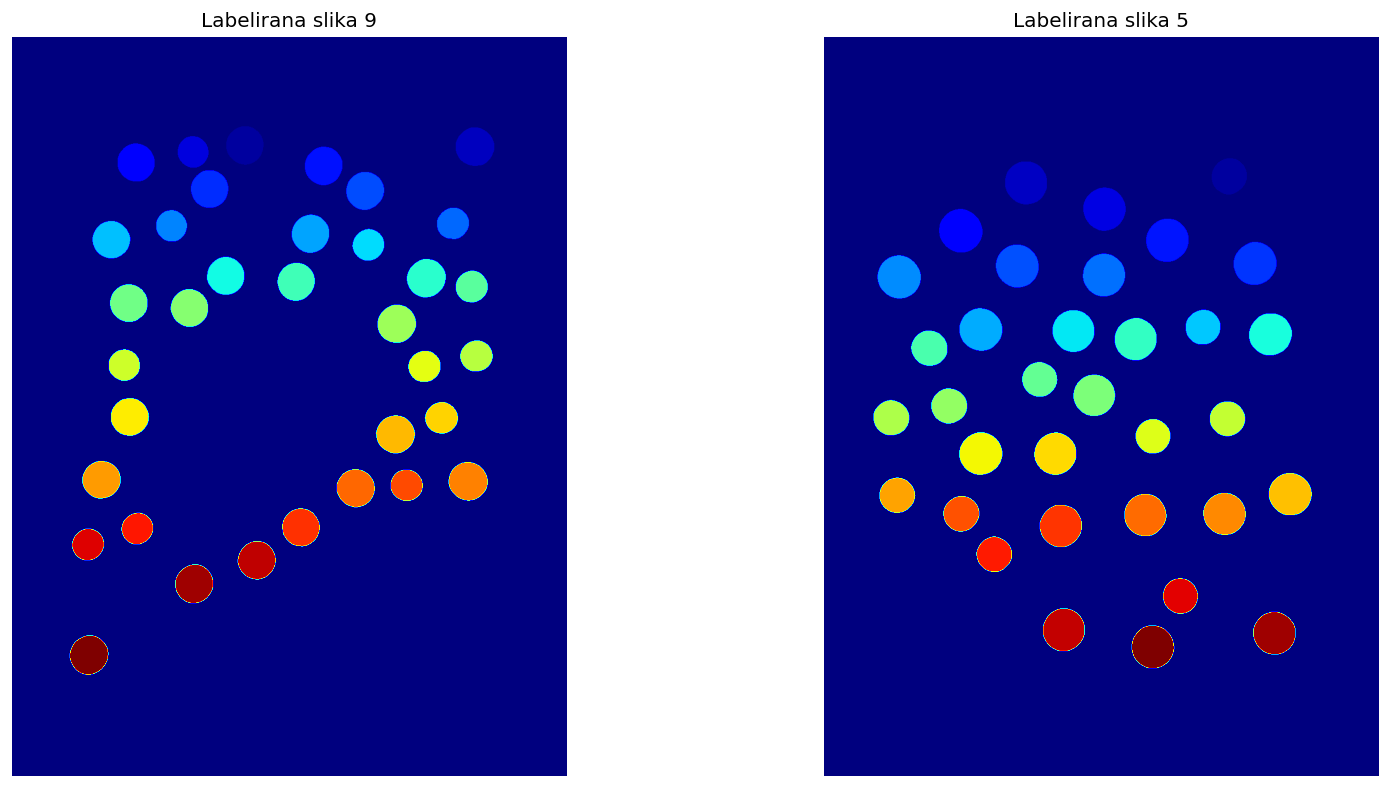

In [8]:
img_label = bw_label(img_bin)
img_label1 = bw_label(img_bin1)

fig,axis = plt.subplots(ncols=2,nrows=1,figsize=(16,8),dpi=120)
ax = axis.ravel()

ax[0].imshow(img_label,cmap='jet'); ax[0].axis('off');ax[0].set_title('Labelirana slika 9');
ax[1].imshow(img_label1,cmap='jet'); ax[1].axis('off');ax[1].set_title('Labelirana slika 5');

3)Napisati funkciju coin_classification koja kao jedini ulazni argument prihvata sliku, a vraća niz od dva broja koji predstavljaju broj novčića sa slike koji pripadaju klasi manje površine (1 dinar) i klasi veće površine (5 dinara) respektivno, koristeći prethodno realizovane funkcije.

In [9]:
def coin_classification(img):
    # Opis funkcije
    #
    # img - Slika sa labeliranim elementima
    # Funkcija radi tako što se za svaku različitu labelu, nalazi broj piksela sa vrednošću te labele, tj. računa se površina svakog novčića.
    # Klasifikacija se vrši tako što se u listi površina koja je uređena rastuće nalazi najveća razlika između članova i na tom mestu se
    # postavlja granica koji su novčići 1, a koji 5 dinara.
    img_klas = copy(img)
    lista = np.ndarray.tolist(np.unique(img)) # Određivanje broja različitih labela
    lista.remove(0)
    lista_povrsina = []
    for i in lista:
        lista_povrsina.append(sum(img==i)) # Računanje površine svake labele i dodavanje u listu povrŠina
    lista_povrsina.sort() # sortiranje liste površina od najmanje ka najvećoj površini
    max = 0
    for i in range(0,len(lista_povrsina)-1):    # Računanje najveće razlike površina i postavljanje granice
        razlika = lista_povrsina[i+1]-lista_povrsina[i] 
        if razlika>max:
            max = razlika
            jedan_dinar=i
            
    jedan = []
    pet = []
    for i in lista:
        if sum(img==i)<=lista_povrsina[jedan_dinar]: # Pravljenje rečnika sa vrednostima 1 i 5 dinara
            jedan.append(i);
        else:
            pet.append(i)
    for i in jedan:
        img_klas[img_klas==i] = 200 # Bojenje novčića od 1 dinar
    for j in pet:
        img_klas[img_klas==j] = 100 # Bojenje novčića od 5 dinara u

    return img_klas,len(jedan),len(pet)
    


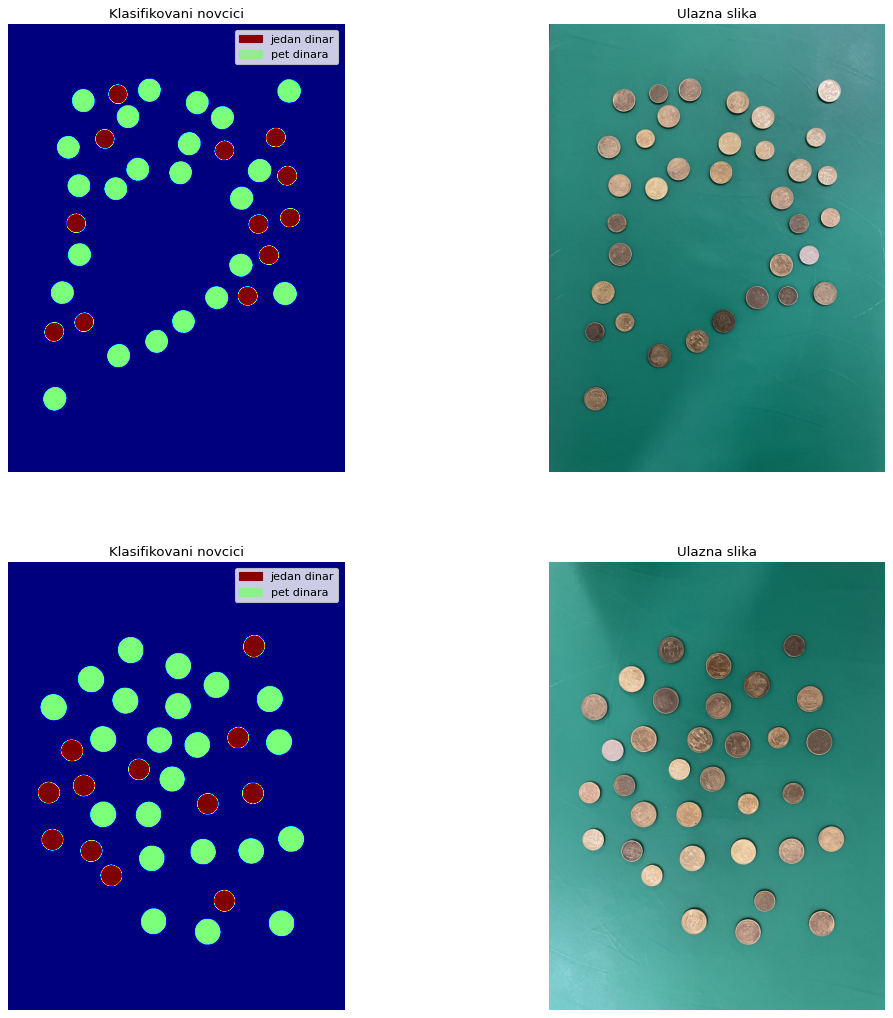

In [10]:

img_klas1,jedan1,pet1 = coin_classification(img_label1)
img_klas,jedan,pet = coin_classification(img_label)


fig,axes = plt.subplots(nrows=2,ncols=2,figsize=(16,16),dpi=80)
ax = axes.ravel()

ax[0].imshow(img_klas,cmap='jet');ax[0].axis('off'); ax[0].set_title('Klasifikovani novcici');
import matplotlib.patches as mpatches
red_patch = mpatches.Patch(color='darkred', label='jedan dinar') # Obeležavanje legende za različite boje
blue_patch = mpatches.Patch(color='lightgreen', label='pet dinara')
ax[0].legend(handles=[red_patch, blue_patch])
ax[1].imshow(img); ax[1].axis('off');ax[1].set_title('Ulazna slika');


ax[2].imshow(img_klas1,cmap='jet');ax[2].axis('off'); ax[2].set_title('Klasifikovani novcici');
ax[2].legend(handles=[red_patch, blue_patch])
ax[3].imshow(img1); ax[3].axis('off');ax[3].set_title('Ulazna slika');


In [11]:
# Iscrtavanje tabele klasifikacije i računanje greška klasifikacije
ref_vr = [[12,34],[4,19],[10,7],[7,4],[12,22],[11,21],[12,34],[12,34],[12,23]]
print('Klasifikovani objekti')
print('[prva klasa, druga klasa]--[ref. vrednost]--[greska]')

ax = axis.ravel()
for i in range(1,10):
    img = imread('coins/coins{}.jpg'.format(i))
    bin_img = coin_mask(img)
    img_label = bw_label(bin_img)
    img_clas,jedan,pet = coin_classification(img_label)
    print('{}. [{} , {}] --  [{} , {}] --  [{},{}]'.format(i,jedan,pet,ref_vr[i-1][0],ref_vr[i-1][1],ref_vr[i-1][0]-jedan,ref_vr[i-1][1]-pet))
   

Klasifikovani objekti
[prva klasa, druga klasa]--[ref. vrednost]--[greska]
1. [12 , 34] --  [12 , 34] --  [0,0]
2. [4 , 19] --  [4 , 19] --  [0,0]
3. [10 , 7] --  [10 , 7] --  [0,0]
4. [7 , 4] --  [7 , 4] --  [0,0]
5. [12 , 22] --  [12 , 22] --  [0,0]
6. [11 , 21] --  [11 , 21] --  [0,0]
7. [12 , 34] --  [12 , 34] --  [0,0]
8. [12 , 34] --  [12 , 34] --  [0,0]
9. [12 , 23] --  [12 , 23] --  [0,0]


# 2. Zadatak:
Napisati funkciju canny_edge_detection koja za ulaznu sliku I, standardnu devijaciju Gausove funkcije sigma i apsolutne vrednosti nižeg i višeg praga (nisu vezani za maksimalni gradijent u slici) detektuje ivice korišćenjem Kanijevog algoritma koji se sastoji iz sledećih koraka:
1. Filtriranje ulazne slike Gausovom funkcijom zadate standardne devijacije. Za veličinu prozora Gausove funkcije uzeti prvi neparni ceo veći ili jednak od 6 sigma.
2. Određivanje horizontalnih i vertikalnih gradijenata tako filtrirane slike.
3. Određivanje magnitude i ugla gradijenta.
4. Kvantizacija gradijenta na jedan od 4 pravaca -45, 0, 45, 90.
5. Potiskivanje vrednosti gradijenata koje ne predstavljaju lokalne maksimume.
6. Određivanje mapa jakih i slabih ivica na osnovu vrednosti nižeg i višeg praga.
7. Uključivanje u izlaznu mapu ivica onih slabih ivica koje su povezane sa nekom jakom ivicom.

In [45]:
def canny_edge_detection(img_in,sigma,lower,upper): 
    # Opis funkcije:
    #
    # Ulazni parametri:
    # img_in - Ulazna slika
    # sigma - Standardna devijacija filtra
    # lower - Niži prag, za slabije ivice
    # upper - Viši prag, za jake ivice
    #
    # Predobrada slike
    img = img_in/255 # Normalizacija na opseg [0,1]
    dim = ceil(6*sigma) # Računanje dimenzije Gausovog filtra
    img = np.pad(img,(1,1),mode='constant') # Pedovanje slike da bi se izbegle dodatne provere graničnih uslova
    if dim%2==0:
        dim=dim+1

    x = np.arange(0,dim)-dim/2 # Pravljenje matrice za filtar
    y = np.arange(0,dim)-dim/2
    [Nx,Ny] = shape(img)
    X,Y = meshgrid(x,y)
    filter_mask =(1/(2*pi*(sigma**2)))*exp(-(np.square(X)+np.square(Y))/(2*sigma**2)) # Pravljenje filter maske
    
    filt_img = ndimage.correlate(img,filter_mask) # Filtriranje slike u prostornom domenu Gausovim filtrom
    #print((dim-1)/2)
    sobel_x = np.array([[-1, -2, -1], # Sobelov gradijentni operator za detekciju horizontalne ivice
                   [0, 0, 0],
                   [1, 2, 1]])
    sobel_y= np.array([[-1, 0, 1], # Sobelov gradijentni operator za detekciju vertikalnih ivica
                   [-2, 0, 2],
                   [-1, 0, 1]])
    x_grad = scipy.ndimage.correlate(filt_img,sobel_x,mode='nearest') # Filtriranje slike sobelovim filtrom
    y_grad = scipy.ndimage.correlate(filt_img,sobel_y,mode='nearest')

    grad  = np.sqrt(np.square(x_grad)+np.square(y_grad)) # Amplituda gradijenta
    teta = np.arctan2(y_grad,x_grad)    # Ugao gradijenta

    # Prebacivanje ugla gradijenta na opseg -45 - 90
    teta = teta/np.pi * 180 # konverzija iz radijana u stepene
    teta[teta>=112.5] -= 180
    teta[teta<-67.5] +=180

    cnt=0
    sup_non_max = np.zeros([Nx,Ny])

    # Kvantizacija uglova i potiskivanje lokalnih nemaksimuma
    # Potiskivanje se vrši tako što se za trenutni piksel pronalazi gradijent i gleda se da li pod uglom normalnim na gradijent u susedstvu
    # postoji piksel sa većom vrednosti amplitude. Ako postoji, trenutni piksel se postavlja na 0, a ako ne postoji trenutni piksel zadržava
    # svoju nenultu vrednost.
    for i in range(1,Nx-1):
        for j in range(1,Ny-1):
            prev = 0
            next = 0
            if( teta[i,j]>=-67.5 and teta[i,j]<-22.5): #Uglovi izmedju -67.5 i -22.5 se posmatraju kao da su -45
                prev = grad[i+1,j-1]
                next = grad[i-1,j+1]
            elif(teta[i,j]>=-22.5 and teta[i,j]<22.5): #Uglovi izmedju -22.5 i 22.5 se posmatraju kao da su 0
                prev = grad[i-1,j]
                next = grad[i+1,j]
            elif(teta[i,j]>=67.5 and teta[i,j]<112.5): #Uglovi izmedju 67.5 i 112.5 se posmatraju kao da su 90
                prev = grad[i,j-1]
                next = grad[i,j+1]
            elif(teta[i,j]>=22,5 and teta[i,j]<67.5): #Uglovi izmedju 22.5 i 67.5 se posmatraju kao da su 45
                prev = grad[i-1,j-1]
                next = grad[i+1,j+1]
            if(grad[i,j]>=next and grad[i,j]>=prev):
                sup_non_max[i,j] = grad[i,j]
    
    # Određivanje mape jakih i slabih ivica
    weak_strong = copy(sup_non_max)
    weak_strong[weak_strong>upper] = 1 # Jake ivice
    weak_strong[weak_strong<lower] = 0 # Slabe ivice

    cnt = 1 
    # Uključivanje u izlaznu mapu slabeih ivica, koje su povezane sa jakim
    while(cnt>0):
        cnt=0
        for i in range(1,Nx-1):
            for j in range(1,Ny-1):
                if(weak_strong[i,j]>0 and weak_strong[i,j]<1): # Provera da trenutni piksel pripada slabim ivicana  
                        if(weak_strong[i-1,j-1]==1 or weak_strong[i-1,j]==1 or # Provera da li se trenutni piksel graniči sa jakim
                            weak_strong[i-1,j+1]==1 or weak_strong[i,j-1]==1 or
                            weak_strong[i,j+1]==1 or weak_strong[i+1,j-1]==1 or weak_strong[i+1,j]==1 or weak_strong[i+1,j+1]==1):
                            weak_strong[i,j] = 1
                            cnt+=1      
    weak_strong[weak_strong<1] = 0
    weak_strong = weak_strong[1:Nx-1,1:Ny-1] # Vraćanje slike na staru dimenziju
    return grad,teta,sup_non_max[1:Nx-1,1:Ny-1],weak_strong

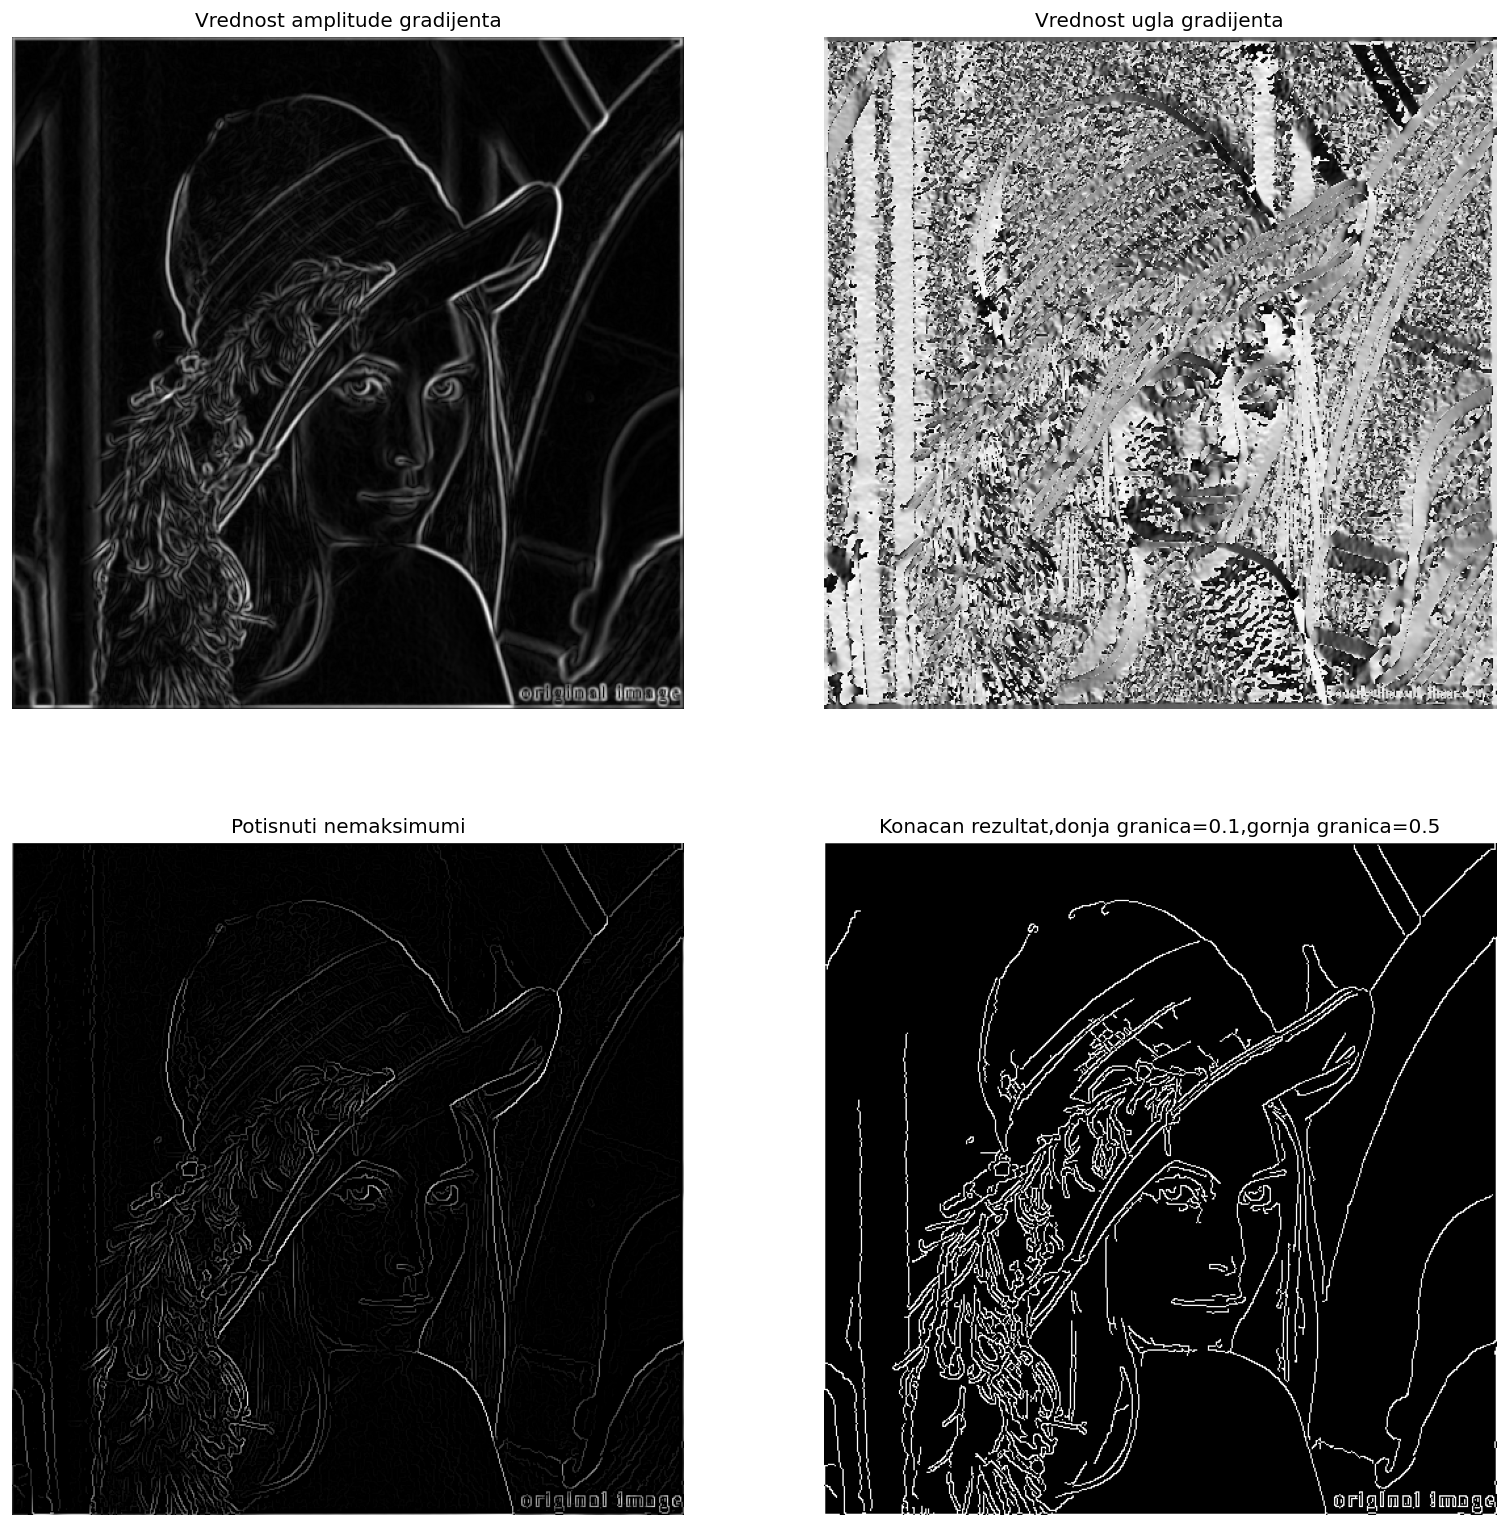

In [46]:

img = imread('lena.tif')
grad,teta,sup_non_max,img_canny = canny_edge_detection(img,1,0.1,0.5)
fig,axes = plt.subplots(nrows=2,ncols=2,figsize=(16,16),dpi=120)
ax = axes.ravel()

ax[0].imshow(grad,cmap='gray'); ax[0].set_title('Vrednost amplitude gradijenta'); ax[0].axis('off');
ax[1].imshow(teta,cmap='gray'); ax[1].set_title('Vrednost ugla gradijenta'); ax[1].axis('off');
ax[2].imshow(sup_non_max,cmap='gray'); ax[2].set_title('Potisnuti nemaksimumi'); ax[2].axis('off');
ax[3].imshow(img_canny,cmap='gray'); ax[3].set_title('Konacan rezultat,donja granica={},gornja granica={}'.format(0.1,0.5)); ax[3].axis('off');


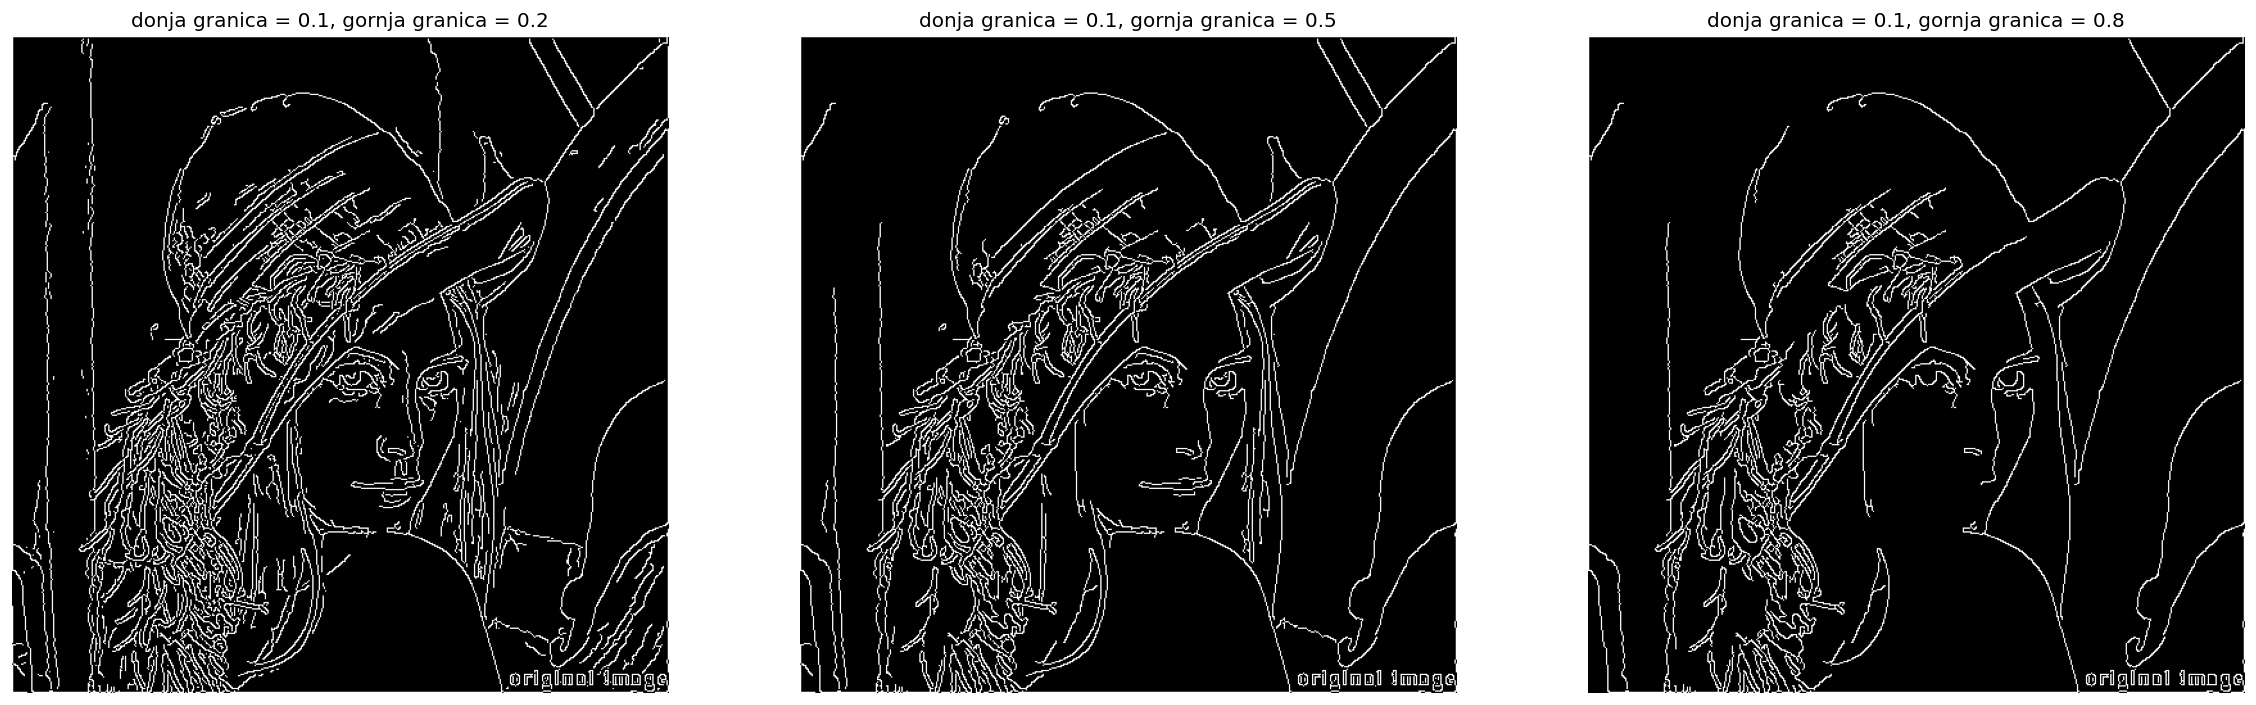

In [47]:
# Testiranje za različit set parametara

grad,teta,sup_non_max,img_canny = canny_edge_detection(img,1,0.1,0.2)
grad1,teta1,sup_non_max1,img_canny1 = canny_edge_detection(img,1,0.1,0.5)
grad2,teta2,sup_non_max2,img_canny2 = canny_edge_detection(img,1,0.1,0.8)

fig,axes = plt.subplots(nrows=1,ncols=3,figsize=(24,16),dpi=120)
ax = axes.ravel()

ax[0].imshow(img_canny,cmap='gray'); ax[0].set_title('donja granica = {}, gornja granica = {}'.format(0.1,0.2)); ax[0].axis('off');
ax[1].imshow(img_canny1,cmap='gray'); ax[1].set_title('donja granica = {}, gornja granica = {}'.format(0.1,0.5)); ax[1].axis('off');
ax[2].imshow(img_canny2,cmap='gray'); ax[2].set_title('donja granica = {}, gornja granica = {}'.format(0.1,0.8)); ax[2].axis('off');


Kao i što je očekivano, što je gornja granica manja, u konačan rezultat ulazi sve više detalja i moguće je pojavljivanje linija koje zapravo nisu ivice, a ukoliko je gornja granica isuviše velika neki detalji će se izgubiti.

3301
841


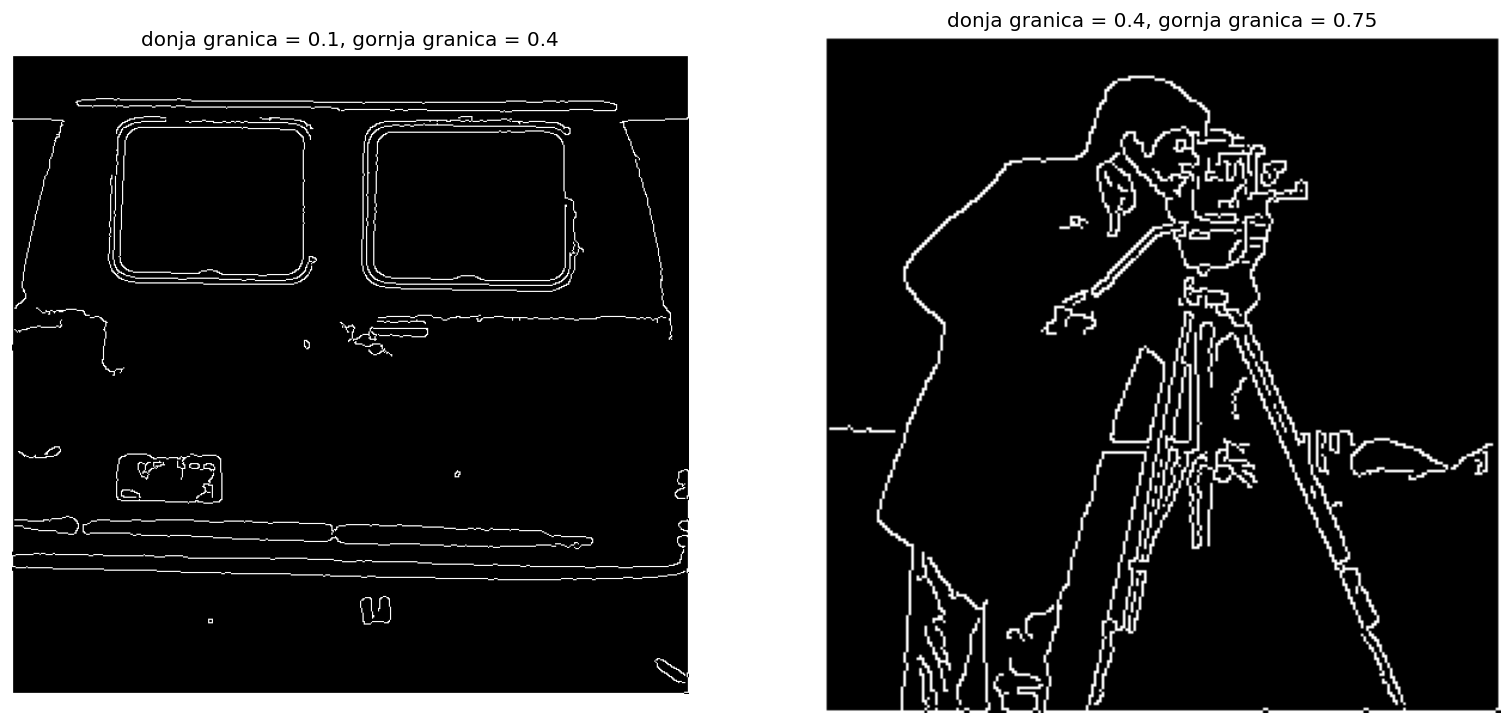

In [42]:
# Testiranje na ostalim slikama
img_van = imread('van.tif')
img_camerman = imread('camerman.tif')

grad3,teta3,sup_non_max3,img_canny3 = canny_edge_detection(img_van,1,0.1,0.6)
grad4,teta4,sup_non_max4,img_canny4 = canny_edge_detection(img_camerman,1,0.4,0.75)
fig,axes = plt.subplots(nrows=1,ncols=2,figsize=(16,16),dpi=120)
ax = axes.ravel()
ax[0].imshow(img_canny3,cmap='gray'); ax[0].set_title('donja granica = {}, gornja granica = {}'.format(0.1,0.4)); ax[0].axis('off');
ax[1].imshow(img_canny4,cmap='gray'); ax[1].set_title('donja granica = {}, gornja granica = {}'.format(0.4,0.75)); ax[1].axis('off');

Zbog velikog šuma na slici kamerman, potrebno je značajno povećati gornju granicu da bi se potisnuo sav šum, tj. da linije nastale od šuma ne bi ušle u krajnji rezultat.